In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [46]:
df = pd.read_csv("VIX.csv")

In [47]:
print(df.head())

         Date       Open       High        Low      Close  Adj Close  Volume
0  1990-01-02  17.240000  17.240000  17.240000  17.240000  17.240000       0
1  1990-01-03  18.190001  18.190001  18.190001  18.190001  18.190001       0
2  1990-01-04  19.219999  19.219999  19.219999  19.219999  19.219999       0
3  1990-01-05  20.110001  20.110001  20.110001  20.110001  20.110001       0
4  1990-01-08  20.260000  20.260000  20.260000  20.260000  20.260000       0


In [48]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337 entries, 0 to 7336
Data columns (total 2 columns):
Date         7337 non-null object
Adj Close    7337 non-null float64
dtypes: float64(1), object(1)
memory usage: 114.7+ KB


In [50]:
df['Date'] = pd.to_datetime(df['Date'])

In [51]:
df = df.set_index(['Date'], drop=True)

In [52]:
df.head(10)

,Adj Close
Date,
1990-01-02,17.240000
1990-01-03,18.190001
1990-01-04,19.219999
1990-01-05,20.110001
1990-01-08,20.260000
1990-01-09,22.200001
1990-01-10,22.440001
1990-01-11,20.049999
1990-01-12,24.639999


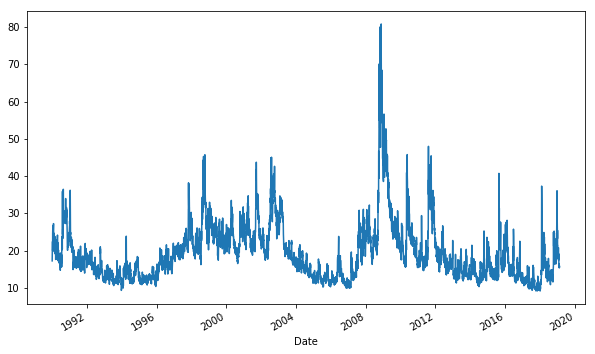

In [53]:
plt.figure(figsize=(10,6))
df['Adj Close'].plot();

In [54]:
split_date = pd.Timestamp('2015-01-01')

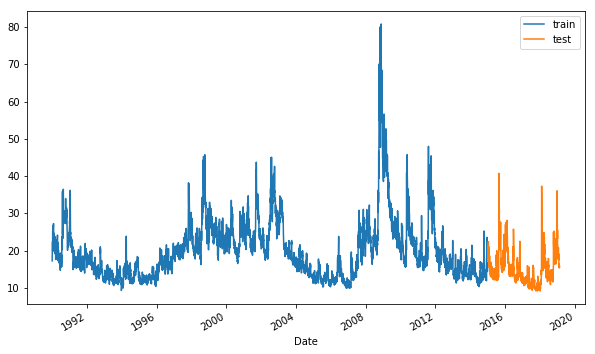

In [55]:
df = df['Adj Close']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10,6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [64]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_sc = scaler.fit_transform(train.values.reshape(-1, 1))
test_sc = scaler.transform(test.values.reshape(-1, 1))

In [67]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [68]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
6300/6300 [==============================] - 20s 3ms/step - loss: 0.0074
Epoch 2/100
6300/6300 [==============================] - 16s 3ms/step - loss: 0.0020
Epoch 3/100
6300/6300 [==============================] - 16s 3ms/step - loss: 0.0020
Epoch 4/100
6300/6300 [==============================] - 15s 2ms/step - loss: 0.0020
Epoch 5/100
6300/6300 [==============================] - 15s 2ms/step - loss: 0.0020
Epoch 6/100
6300/6300 [==============================] - 16s 2ms/step - loss: 0.0020
Epoch 7/100
6300/6300 [==============================] - 16s 2ms/step - loss: 0.0020
Epoch 8/100
6300/6300 [==============================] - 16s 3ms/step - loss: 0.0020
Epoch 9/100
6300/6300 [==============================] - 15s 2ms/step - loss: 0.0020
Epoch 10/100
6300/6300 [==============================] - 16s 2ms/step - loss: 0.0020
Epoch 11/100
6300/6300 [==============================] - 16s 2ms/step - loss: 0.0019
Epoch 12/100
6300/6300 [==============================] - 16s 3

In [69]:
y_test_pred_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred_nn)))

The R2 score on the Train set is:	0.920
The R2 score on the Test set is:	0.824


In [72]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

In [73]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (6300, 1, 1)
Test shape:  (1035, 1, 1)


In [74]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
6300/6300 [==============================] - 35s 5ms/step - loss: 0.0110
Epoch 2/100
6300/6300 [==============================] - 34s 5ms/step - loss: 0.0020
Epoch 3/100
6300/6300 [==============================] - 34s 5ms/step - loss: 0.0019
Epoch 4/100
6300/6300 [==============================] - 34s 5ms/step - loss: 0.0019
Epoch 5/100
6300/6300 [==============================] - 33s 5ms/step - loss: 0.0019
Epoch 6/100
6300/6300 [==============================] - 33s 5ms/step - loss: 0.0019
Epoch 7/100
6300/6300 [==============================] - 33s 5ms/step - loss: 0.0019
Epoch 8/100
6300/6300 [==============================] - 33s 5ms/step - loss: 0.0019
Epoch 9/100
6300/6300 [==============================] - 33s 5ms/step - loss: 0.0019
Epoch 10/100
6300/6300 [==============================] - 33s 5ms/step - loss: 0.0019
Epoch 11/100
6300/6300 [==============================] - 33s 5ms/step - loss: 0.0019
Epoch 12/100
6300/6300 [==============================] - 33s 5

In [75]:
y_test_pred_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred_lstm)))

The R2 score on the Train set is:	0.940
The R2 score on the Test set is:	0.860


In [76]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

1035/1035 [==============================] - 2s 2ms/step
NN: 0.002854
LSTM: 0.002267


In [77]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

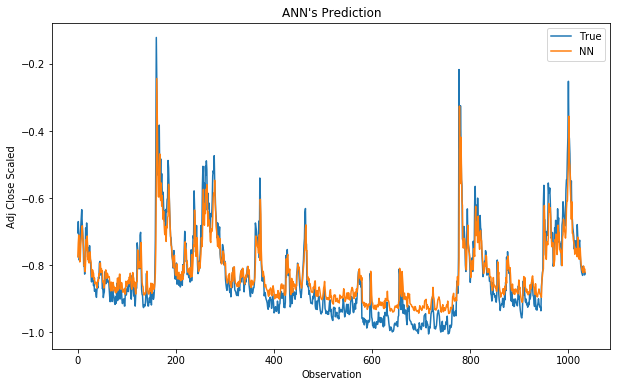

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_test_pred_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

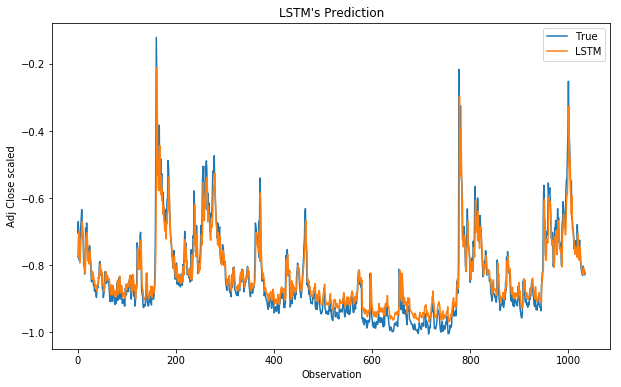

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_test_pred_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();